In [1]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Conv1D,Conv2D,Flatten,BatchNormalization,MaxPooling1D,Dropout,Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam,SGD
import datetime
from tensorflow.keras.utils import plot_model
import os
import flask
import json


# def load_dataset():

ddata = pd.read_csv('./final_1/final_1l.csv')

In [2]:
df = ddata
# df = ddata[ddata['Label'] != 'DDOS']


In [3]:
# drop columns
df.drop(['Timestamp','Fwd Header Len'], axis=1, inplace=True)
df.drop(['Protocol'], axis=1, inplace=True)
# df.drop(['Dst Port'], axis=1, inplace=True)

In [4]:
# duplicated
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

58334


In [5]:
df.dropna(axis=0, inplace=True, how="any")

In [6]:
# Checking if all values are finite.
np.all(np.isfinite(df.drop(['Label'], axis=1)))

# drop inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True,how='any',axis=0)


In [7]:
# df.drop(['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'], axis=1,inplace=True)

# drop std < 0.01
dataset_std = df.std(numeric_only=True)
columns_to_drop = [column for column, std in dataset_std.iteritems() if std < 0.01]
print(columns_to_drop)
df.drop(columns=columns_to_drop, inplace=True)

['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg']


C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\502833103.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  columns_to_drop = [column for column, std in dataset_std.iteritems() if std < 0.01]


In [8]:
dataset_corr = df.corr()
dataset_corr.head(5)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\306764757.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Dst Port,1.000000,-0.002432,-0.051977,-0.033787,-0.011109,-0.018327,-0.295544,-0.227649,-0.342371,-0.297494,...,-0.248591,0.335009,-0.059460,-0.059195,-0.075916,-0.051897,0.294379,-0.034433,0.289798,0.296636
Flow Duration,-0.002432,1.000000,-0.006097,0.001983,0.000295,0.001461,0.005750,-0.001388,0.003705,0.005395,...,0.009545,0.001352,0.002581,0.005715,0.004631,0.001814,-0.002589,0.001084,-0.002479,-0.002674
Tot Fwd Pkts,-0.051977,-0.006097,1.000000,0.869820,0.064361,0.863474,0.130913,-0.035162,0.079187,0.102935,...,0.253782,-0.024976,0.072249,0.101444,0.105595,0.058006,-0.045744,0.019606,-0.043769,-0.047305
Tot Bwd Pkts,-0.033787,0.001983,0.869820,1.000000,0.066794,0.996794,0.086963,-0.020367,0.043821,0.058543,...,0.202439,-0.012132,0.064416,0.084724,0.091901,0.052392,-0.025071,0.011455,-0.023926,-0.025987
TotLen Fwd Pkts,-0.011109,0.000295,0.064361,0.066794,1.000000,0.010488,0.355070,-0.005565,0.394436,0.260306,...,0.504123,-0.004901,0.008831,0.010930,0.012196,0.007392,-0.009337,0.004987,-0.008847,-0.009739


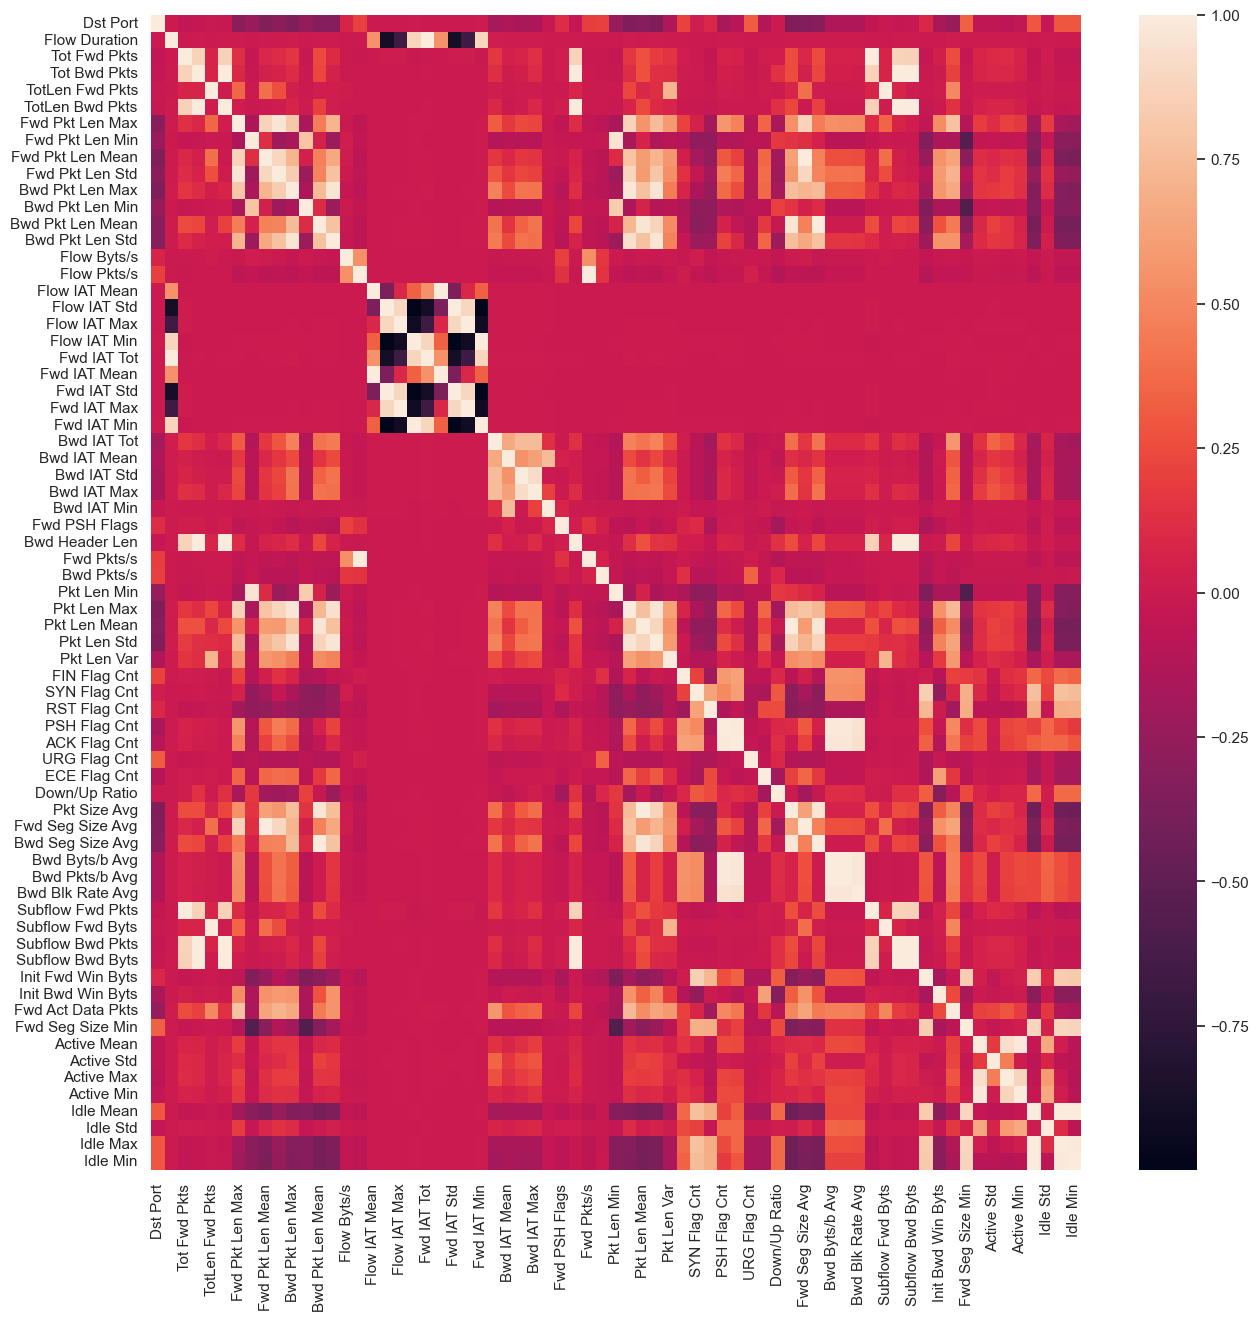

In [9]:
fig = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.0)
ax = sns.heatmap(dataset_corr, annot=False)
fig.savefig(os.path.join('./images', 'correlation matrix.pdf'))

In [10]:
# Create & Apply mask
mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
tri_df = dataset_corr.mask(mask)

# Find Features that meet the threshold
correlated_features = [c for c in tri_df.columns if any(tri_df[c] > 0.98)]
print(correlated_features)
# Drop the highly correlated features
df.drop(labels=correlated_features, axis=1, inplace=True)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Bwd Header Len', 'Pkt Len Mean', 'PSH Flag Cnt', 'Bwd Byts/b Avg', 'Subflow Bwd Pkts', 'Active Mean', 'Idle Mean', 'Idle Max']


In [11]:
# drop columns
print(df.info())
train_dataset = df
print(train_dataset['Label'].value_counts())
# df.to_csv('./final_1/final_had_p.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737931 entries, 0 to 799999
Data columns (total 50 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           737931 non-null  int64  
 1   Fwd Pkt Len Max    737931 non-null  float64
 2   Fwd Pkt Len Min    737931 non-null  float64
 3   Fwd Pkt Len Std    737931 non-null  float64
 4   Bwd Pkt Len Max    737931 non-null  float64
 5   Bwd Pkt Len Min    737931 non-null  float64
 6   Bwd Pkt Len Std    737931 non-null  float64
 7   Flow Byts/s        737931 non-null  float64
 8   Fwd IAT Tot        737931 non-null  float64
 9   Fwd IAT Mean       737931 non-null  float64
 10  Fwd IAT Std        737931 non-null  float64
 11  Fwd IAT Max        737931 non-null  float64
 12  Fwd IAT Min        737931 non-null  float64
 13  Bwd IAT Tot        737931 non-null  float64
 14  Bwd IAT Mean       737931 non-null  float64
 15  Bwd IAT Std        737931 non-null  float64
 16  Bw

In [12]:
# encode label
labelE = LabelEncoder()
train_dataset['Label'] = labelE.fit_transform(train_dataset['Label'])
train_dataset['Label'].value_counts()
y = train_dataset['Label']
train_dataset = train_dataset.drop(['Label'],axis=1)

In [13]:
# normalize data
sc = StandardScaler()
train_dataset = sc.fit_transform(train_dataset)
train_dataset = pd.DataFrame(train_dataset,columns=df.columns[:-1])

In [14]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.1, random_state=42)

In [15]:
def re_shape(X_train,X_test,y_train,y_test):
    X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1],1)
    X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1],1)
    return X_train,X_test,y_train,y_test



def mutil_head_double_layers_evaluate_model(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    conv1d_1s2 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(maxpool_1s1)
    batch_1s2 = BatchNormalization()(conv1d_1s2)
    maxpool_1s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s2)
    flat1 = Flatten()(maxpool_1s2)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    conv1d_2s2 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(maxpool_2s1)
    batch_2s2 = BatchNormalization()(conv1d_2s2)
    maxpool_2s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s2)
    flat2 = Flatten()(maxpool_2s2)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    conv1d_3s2 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(maxpool3)
    batch_3s2 = BatchNormalization()(conv1d_3s2)
    maxpool_3s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s2)
    flat3 = Flatten()(maxpool_3s2)

    concat = concatenate([flat1,flat2])
    dense1 = Dense(256,activation='relu')(concat)
    drop = Dropout(0.2)(dense1)
    dense2 = Dense(4,activation='softmax')(drop)
    model = Model(inputs=[input1s,input2s],outputs=dense2)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest],ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

def mutil_head_double_layers_evaluate_model1(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    flat1 = Flatten()(maxpool_1s1)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    flat2 = Flatten()(maxpool_2s1)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    flat3 = Flatten()(maxpool3)

    concat = concatenate([flat1,flat2])
    dense1 = Dense(1024,activation='relu')(concat)
    drop1 = Dropout(0.5)(dense1)

    dense2 = Dense(256,activation='relu')(drop1)
    drop2 = Dropout(0.5)(dense2)
    dense3 = Dense(4,activation='softmax')(drop2)
    model = Model(inputs=[input1s,input2s],outputs=dense3)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest],ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

In [16]:
X_train,X_test,y_train,y_test = re_shape(X_train,X_test,y_train,y_test)

In [17]:
# %tensorboard --logdir logs/fit
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
os.mkdir(f'./models/{time}')
logdir="logs/multi/" + time +'/'
model = mutil_head_double_layers_evaluate_model1(time,X_train,y_train,X_test,y_test,logdir,20,512)
model.save(f'models/{time}/model_{time}.h5')

c:\Users\fancyma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1298/1298 [==============================] - 21s 11ms/step - loss: 0.1637 - accuracy: 0.9393 - val_loss: 0.1245 - val_accuracy: 0.9552
Epoch 2/20
1298/1298 [==============================] - 14s 11ms/step - loss: 0.1306 - accuracy: 0.9521 - val_loss: 0.1307 - val_accuracy: 0.9533
Epoch 3/20
1298/1298 [==============================] - 14s 11ms/step - loss: 0.1272 - accuracy: 0.9534 - val_loss: 0.1194 - val_accuracy: 0.9569
Epoch 4/20
1298/1298 [==============================] - 14s 11ms/step - loss: 0.1254 - accuracy: 0.9540 - val_loss: 0.1203 - val_accuracy: 0.9562
Epoch 5/20
1298/1298 [==============================] - 15s 11ms/step - loss: 0.1243 - accuracy: 0.9543 - val_loss: 0.1259 - val_accuracy: 0.9569
Epoch 6/20
1298/1298 [==============================] - 14s 11ms/step - loss: 0.1234 - accuracy: 0.9546 - val_loss: 0.1234 - val_accuracy: 0.9574
Epoch 7/20
1298/1298 [==============================] - 14s 11ms/step - loss: 0.1230 - accuracy: 0.9549 - val_loss: 0.1415 -

In [18]:
da = pd.DataFrame(y_test)
da.value_counts()

Label
0        44097
1         9981
3         9921
2         9795
dtype: int64

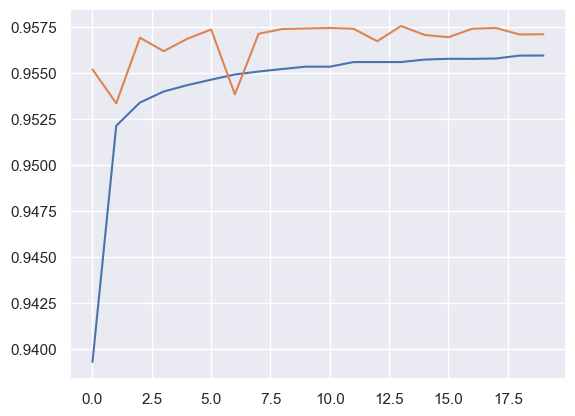

In [19]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])